In [0]:
#Zhipeng Hong 
#analytic goal: Predict whether user will voted up for a game
#machine learning algorithm : Random Forest

In [0]:
%%time
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

CPU times: user 274 µs, sys: 72 µs, total: 346 µs
Wall time: 351 µs

In [0]:
spark = SparkSession.builder.config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1")\
                            .config("spark.network.timeout", "36000000000s")\
                            .config("spark.executor.heartbeatInterval", "36000000000s")\
                            .getOrCreate()

In [0]:
database = 'steam'
collection = 'steam'
user_name = 'jim'
password = 'jim'
address = 'gogogo.chu66.mongodb.net'
connection_string = f"mongodb+srv://{user_name}:{password}@{address}/{database}.{collection}"

In [0]:
df = spark.read.format("mongo").option("uri",connection_string).load()

In [0]:
%%time
def indexStringColumns(df, cols):
    # variable newdf will be updated several times
    newdf = df
    
    for c in cols:
        # For each given colum, fits StringIndexerModel.
        si = StringIndexer(inputCol=c, outputCol=c+"-num")
        sm = si.fit(newdf)
        
        # Creates a DataFame by putting the transformed values in the new colum with suffix "-num" 
        # and then drops the original columns.
        # and drop the "-num" suffix. 
        newdf = sm.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-num", c)
    return newdf
def oneHotEncodeColumns(df, cols):
    newdf = df
    for c in cols:
        ohe = OneHotEncoder(inputCol=c, outputCol=c+"-onehot", dropLast=False)
        ohe_model = ohe.fit(newdf)

        newdf = ohe_model.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-onehot", c)
    return newdf

CPU times: user 14 µs, sys: 3 µs, total: 17 µs
Wall time: 23.1 µs

In [0]:
df.show()

+--------------------+------------+-----+----------------+--------------------+--------------------+-------+-------------------+---------------+--------------------+----------------+---------------+-----------+------------------+-----------------+------------------+----------------+----------------+-----+---------+-------------------+------------+--------------------+-----------------+--------------------+-------------------+-------------------+--------+-----------+--------+-------------------+
 _id|achievements|appid|average_playtime| categories| developer|english| genres|median_playtime| name|negative_ratings|num_games_owned|num_reviews| owners| platforms|playtime_at_review|playtime_forever|positive_ratings|price|publisher| release_date|required_age| review| steamid| steamspy_tags| timestamp_created| timestamp_updated|voted_up|votes_funny|votes_up|weighted_vote_score|
+--------------------+------------+-----+----------------+--------------------+--------------------+-------+-------------------+---------------+--------------------+----------------+---------------+-----------+------------------+-----------------+------------------+----------------+----------------+-----+---------+-------------------+------------+--------------------+-----------------+--------------------+-------------------+-------------------+--------+-----------+--------+-------------------+
{6215657d807c5441...| 167| 730| 22494.0|Multi-player;Stea...|Valve;Hidden Path...| 1|Action;Free to Play| 6502.0|Counter-Strike: G...| 402313| 3| 2|50000000-100000000|windows;mac;linux| 11581| 37438| 2644404| 0.0| Valve|2012-08-21 00:00:00| 0| Tec-9 | Red Quartz|76561198804578282|FPS;Multiplayer;S...|2018-09-13 23:15:22|2018-09-13 23:15:22| true| 0| 1| 0|
{6215657d807c5441...| 167| 730| 22494.0|Multi-player;Stea...|Valve;Hidden Path...| 1|Action;Free to Play| 6502.0|Counter-Strike: G...| 402313| 7| 2|50000000-100000000|windows;mac;linux| 5344| 8819| 2644404| 0.0| Valve|2012-08-21 00:00:00| 0|Was my favorite g...|76561198211586393|FPS;Multiplayer;S...|2018-09-13 22:41:28|2018-09-13 22:41:28| true| 0| 0| 0|
{6215657d807c5441...| 167| 730| 22494.0|Multi-player;Stea...|Valve;Hidden Path...| 1|Action;Free to Play| 6502.0|Counter-Strike: G...| 402313| 16| 1|50000000-100000000|windows;mac;linux| 81075| 161081| 2644404| 0.0| Valve|2012-08-21 00:00:00| 0| shit|76561198839820249|FPS;Multiplayer;S...|2018-09-13 21:51:11|2019-07-02 11:52:06| true| 0| 0| 0|
{6215657d807c5441...| 167| 730| 22494.0|Multi-player;Stea...|Valve;Hidden Path...| 1|Action;Free to Play| 6502.0|Counter-Strike: G...| 402313| 32| 1|50000000-100000000|windows;mac;linux| 151849| 243110| 2644404| 0.0| Valve|2012-08-21 00:00:00| 0| fUn aT TimES|76561198248396892|FPS;Multiplayer;S...|2018-09-13 21:50:57|2018-09-13 21:50:57| true| 0| 0| 0|
{6215657d807c5441...| 167| 730| 22494.0|Multi-player;Stea...|Valve;Hidden Path...| 1|Action;Free to Play| 6502.0|Counter-Strike: G...| 402313| 14| 1|50000000-100000000|windows;mac;linux| 23220| 37172| 2644404| 0.0| Valve|2012-08-21 00:00:00| 0|CS go is a game w...|76561198016654603|FPS;Multiplayer;S...|2018-09-13 21:46:29|2018-09-13 21:46:29| false| 1| 4| 0|
{6215657d807c5441...| 167| 730| 22494.0|Multi-player;Stea...|Valve;Hidden Path...| 1|Action;Free to Play| 6502.0|Counter-Strike: G...| 402313| 2| 3|50000000-100000000|windows;mac;linux| 1644| 33311| 2644404| 0.0| Valve|2012-08-21 00:00:00| 0| i Love this game <3|76561198859285548|FPS;Multiplayer;S...|2018-09-13 21:39:20|2018-09-13 21:39:20| true| 0| 0| 0|
{6215657d807c5441...| 167| 730| 22494.0|Multi-player;Stea...|Valve;Hidden Path...| 1|Action;Free to Play| 6502.0|Counter-Strike: G...| 402313| 71| 1|50000000-100000000|windows;mac;linux| 19581| 41173| 2644404| 0.0| Valve|2012-08-21 00:00:00| 0|this game is gud ...|76561198803063781|FPS;Multiplayer;S...|2018-09-13 21:25:19|2018-09-13 21:25:19| true| 1| 0| 0|
{6215657d807c5441...| 167| 730| 22494.0|Multi-player;Stea...|Valve;Hidden Path...| 1|Action;Free to Play| 6502.0|Counter-S

In [0]:
df.printSchema()

root
-- _id: struct (nullable = true)
 |-- oid: string (nullable = true)
-- achievements: integer (nullable = true)
-- appid: integer (nullable = true)
-- average_playtime: double (nullable = true)
-- categories: string (nullable = true)
-- developer: string (nullable = true)
-- english: integer (nullable = true)
-- genres: string (nullable = true)
-- median_playtime: double (nullable = true)
-- name: string (nullable = true)
-- negative_ratings: integer (nullable = true)
-- num_games_owned: integer (nullable = true)
-- num_reviews: integer (nullable = true)
-- owners: string (nullable = true)
-- platforms: string (nullable = true)
-- playtime_at_review: integer (nullable = true)
-- playtime_forever: integer (nullable = true)
-- positive_ratings: integer (nullable = true)
-- price: double (nullable = true)
-- publisher: string (nullable = true)
-- release_date: timestamp (nullable = true)
-- required_age: integer (nullable = true)
-- review: string (nullable = true)
-- steamid: long (nullable = true)
-- steamspy_tags: string (nullable = true)
-- timestamp_created: timestamp (nullable = true)
-- timestamp_updated: timestamp (nullable = true)
-- voted_up: boolean (nullable = true)
-- votes_funny: integer (nullable = true)
-- votes_up: integer (nullable = true)
-- weighted_vote_score: integer (nullable = true)

In [0]:
%%time
cols=["appid","platforms","num_games_owned","num_reviews",
      "developer","price","publisher","playtime_at_review","playtime_forever",
      "negative_ratings","positive_ratings","voted_up"]
steam=df.select(cols)
# steam=steam.withColumn("game_rating",(steam["positive_ratings"]/(steam["negative_ratings"]+steam["positive_ratings"])))
steam=steam.drop("positive_ratings","negative_ratings")
steam=steam.withColumn("voted_up",steam["voted_up"].cast(IntegerType()))
steam=steam.withColumnRenamed("voted_up","label")
steam=steam.dropna()

CPU times: user 5.63 ms, sys: 4.64 ms, total: 10.3 ms
Wall time: 90.7 ms

In [0]:
steam.printSchema()

root
-- appid: integer (nullable = true)
-- platforms: string (nullable = true)
-- num_games_owned: integer (nullable = true)
-- num_reviews: integer (nullable = true)
-- developer: string (nullable = true)
-- price: double (nullable = true)
-- publisher: string (nullable = true)
-- playtime_at_review: integer (nullable = true)
-- playtime_forever: integer (nullable = true)
-- label: integer (nullable = true)

In [0]:
cols=["platforms","developer","publisher"]
steam=indexStringColumns(steam, cols)    

In [0]:
steam.show()

+-----+---------------+-----------+-----+------------------+----------------+-----+---------+---------+---------+
appid|num_games_owned|num_reviews|price|playtime_at_review|playtime_forever|label|platforms|developer|publisher|
+-----+---------------+-----------+-----+------------------+----------------+-----+---------+---------+---------+
 730| 3| 2| 0.0| 11581| 37438| 1| 1.0| 0.0| 0.0|
 730| 7| 2| 0.0| 5344| 8819| 1| 1.0| 0.0| 0.0|
 730| 16| 1| 0.0| 81075| 161081| 1| 1.0| 0.0| 0.0|
 730| 32| 1| 0.0| 151849| 243110| 1| 1.0| 0.0| 0.0|
 730| 14| 1| 0.0| 23220| 37172| 0| 1.0| 0.0| 0.0|
 730| 2| 3| 0.0| 1644| 33311| 1| 1.0| 0.0| 0.0|
 730| 71| 1| 0.0| 19581| 41173| 1| 1.0| 0.0| 0.0|
 730| 6| 1| 0.0| 135399| 315836| 1| 1.0| 0.0| 0.0|
 730| 1| 1| 0.0| 6990| 25462| 1| 1.0| 0.0| 0.0|
 730| 14| 1| 0.0| 28942| 64876| 1| 1.0| 0.0| 0.0|
 730| 57| 1| 0.0| 54956| 67188| 0| 1.0| 0.0| 0.0|
 730| 55| 2| 0.0| 12179| 68053| 0| 1.0| 0.0| 0.0|
 730| 67| 8| 0.0| 690| 2088| 1| 1.0| 0.0| 0.0|
 730| 80| 3| 0.0| 22454| 35810| 1| 1.0| 0.0| 0.0|
 730| 21| 2| 0.0| 9243| 23742| 1| 1.0| 0.0| 0.0|
 730| 1| 1| 0.0| 6692| 7731| 1| 1.0| 0.0| 0.0|
 730| 47| 2| 0.0| 92439| 249440| 0| 1.0| 0.0| 0.0|
 730| 13| 7| 0.0| 851| 37961| 1| 1.0| 0.0| 0.0|
 730| 3| 3| 0.0| 2879| 3007| 1| 1.0| 0.0| 0.0|
 730| 23| 2| 0.0| 51044| 84419| 1| 1.0| 0.0| 0.0|
+-----+---------------+-----------+-----+------------------+----------------+-----+---------+---------+---------+
only showing top 20 rows

In [0]:
%%time
inputCols=["appid","num_games_owned","num_reviews","price","playtime_at_review",
           "playtime_forever","platforms","developer","publisher"]
va = VectorAssembler(outputCol="features", inputCols=inputCols) 
steam_df = va.transform(steam).select("features", "label")

CPU times: user 7.44 ms, sys: 769 µs, total: 8.21 ms
Wall time: 87.3 ms

In [0]:
%%time
steam_split=steam_df.randomSplit([0.8,0.2])
steam_train = steam_split[0].cache()
steam_valid = steam_split[1].cache()

CPU times: user 1.58 ms, sys: 427 µs, total: 2 ms
Wall time: 134 ms

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
rf = RandomForestClassifier()
evaluator = BinaryClassificationEvaluator().setLabelCol("label").setMetricName("areaUnderPR")
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [10]).addGrid(rf.maxBins, [6000]).addGrid(rf.numTrees,[10,15]).build()

cv = CrossValidator(estimator=rf, 
                    evaluator=evaluator, 
                    numFolds=2, 
                    estimatorParamMaps=paramGrid)

In [0]:
%%time
cvmodel = cv.fit(steam_train)

CPU times: user 4.67 s, sys: 1.86 s, total: 6.54 s
Wall time: 27min 34s

In [0]:
prediction = cvmodel.bestModel.transform(steam_valid)

In [0]:
tree=cvmodel.bestModel
imp=list(zip(va.getInputCols(), tree.featureImportances))

In [0]:
%%time
print(tree)
print("Best Max Depth : %s" % cvmodel.bestModel.getMaxDepth)
print("Accuracy : %s" % evaluator.evaluate(prediction))

RandomForestClassificationModel: uid=RandomForestClassifier_41830d4eb121, numTrees=15, numClasses=2, numFeatures=9
Best Max Depth : <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_41830d4eb121, numTrees=15, numClasses=2, numFeatures=9>
Accuracy : 0.9566667325053522
CPU times: user 169 ms, sys: 64.4 ms, total: 233 ms
Wall time: 1min 1s

In [0]:
imp

Out[29]: [('appid', 0.038675657718742894),
 ('num_games_owned', 0.019361421961906208),
 ('num_reviews', 0.004882206959897457),
 ('price', 0.13997175186843341),
 ('playtime_at_review', 0.1977170757036001),
 ('playtime_forever', 0.38926092582733635),
 ('platforms', 0.02657545705649251),
 ('developer', 0.11993465126314606),
 ('publisher', 0.06362085164044498)]

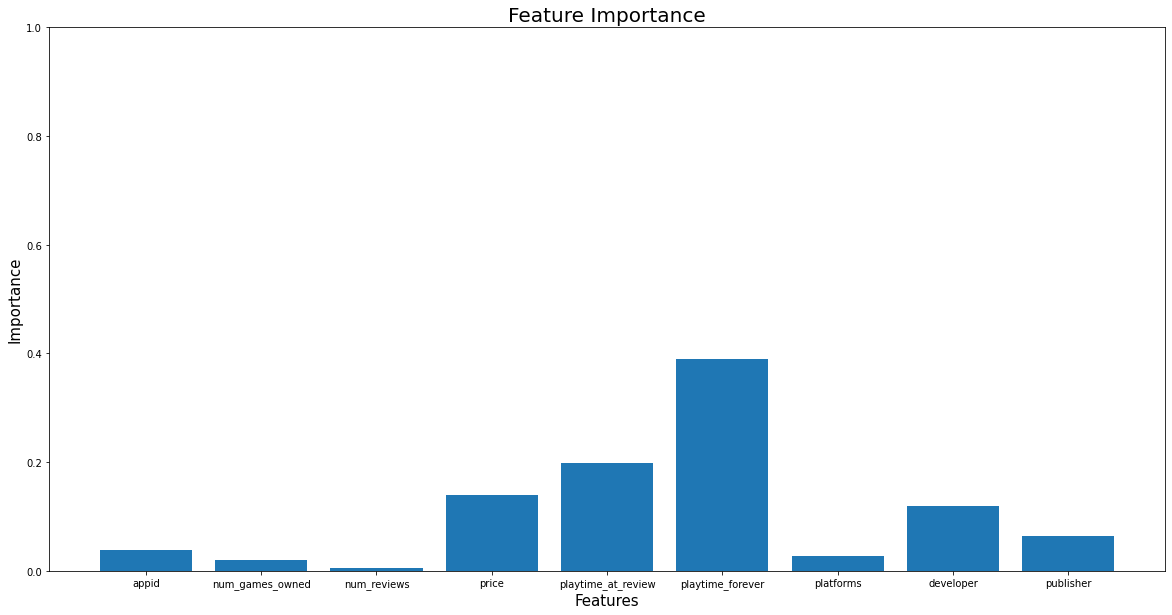

In [0]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(20,10))
ax.bar([x[0] for x in imp],[x[1] for x in imp])
ax.set_title("Feature Importance",fontsize=20)
ax.set_xlabel("Features",fontsize=15)
ax.set_ylabel("Importance",fontsize=15)
ax.set_ybound(0,1)